In [3]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%load_ext autoreload
%autoreload 2

import os
import re
import json

import pycocotools.coco
import pycocotools.cocoeval

import numpy as np

import torch
import torchvision

from trt_pose.utils.export_for_isaac import InputReNormalization, HeatmapMaxpoolAndPermute
import trt_pose.models
import trt_pose.plugins

from trt_pose.draw_objects import DrawObjects
from trt_pose.parse_objects import ParseObjects

import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import PIL.Image
import seaborn as sns

from utils import assemble_model, get_file_list_in_order, draw_image
from utils import prepare_image
from utils import get_part_linkage_topology

In [7]:
DENSENET_PATH = "../models/densenet121_baseline_att_256x256_B_epoch_160.pth"
DENSENET_INPUT_SHAPE = (256, 256)

RESNET_PATH = "../models/resnet18_baseline_att_224x224_A_epoch_249.pth"
RESNET_INPUT_SHAPE = (224, 224)

FITNESS_FOLDER = "../video/fitness"
TEST_IMAGE = "../video/fitness/out1000.jpg"

TEST_IMAGE = "girl.jpg"
MODEL = RESNET_PATH
INPUT_SHAPE = RESNET_INPUT_SHAPE

In [25]:
with open('human_pose.json', 'r') as f:
    human_pose = json.load(f)
topology = trt_pose.coco.coco_category_to_topology(human_pose)
num_parts = len(human_pose['keypoints'])
num_links = len(human_pose['skeleton'])
converted_model_resnet18 = trt_pose.models.MODELS["resnet18_baseline_att"](num_parts, num_links * 2).eval().cuda()

(240, 320, 3)


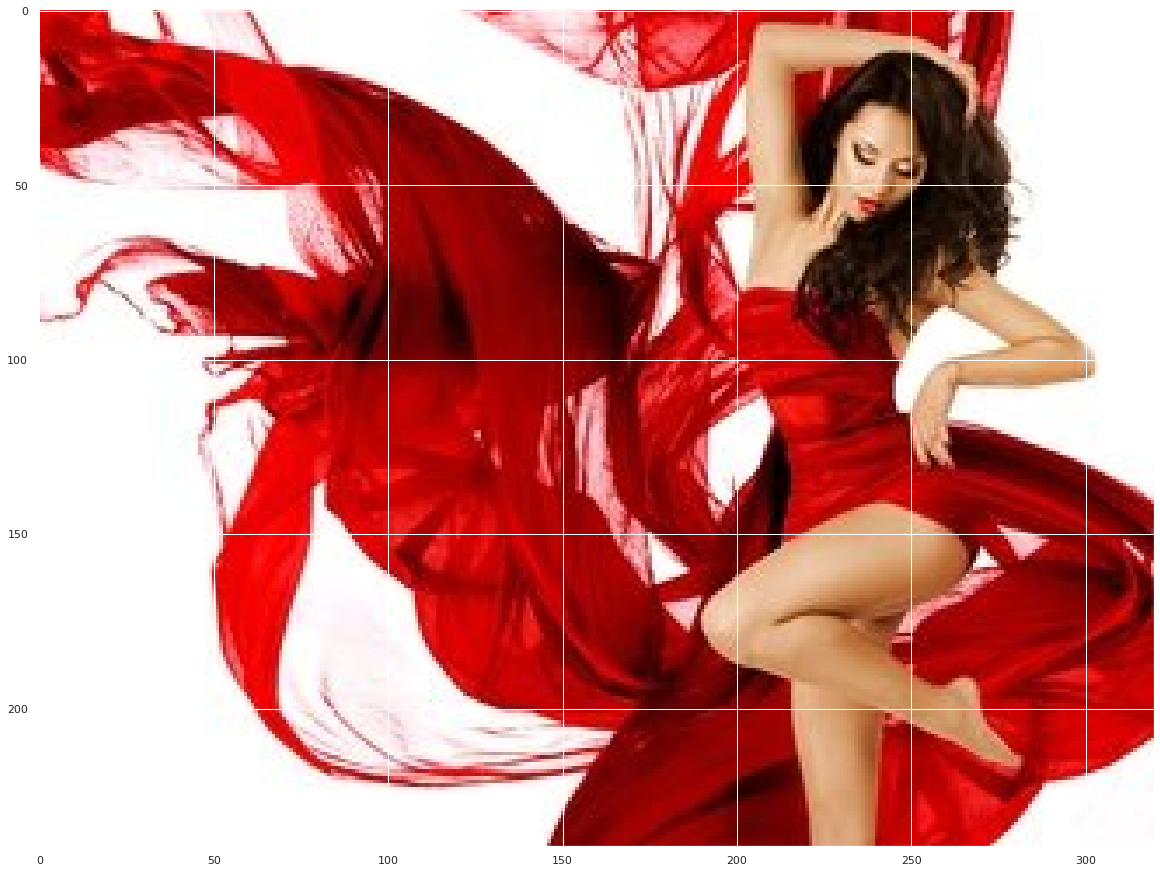

In [26]:
image = cv2.imread(TEST_IMAGE) #image in BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #image in RGB
plt.figure(figsize=(20, 20))
plt.imshow(image)
print(image.shape)

In [27]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    # torchvision.transforms.CenterCrop(224),
    torchvision.transforms.Resize(INPUT_SHAPE),    
])

image_transformed = transform(image).cuda()
image_transformed = torch.unsqueeze(image_transformed, 0)
print(image_transformed.size())
image_transformed

torch.Size([1, 3, 224, 224])


tensor([[[[ 1.7859,  1.8426,  1.9197,  ...,  2.2489,  2.2489,  2.2489],
          [ 1.6612,  1.6943,  1.6930,  ...,  2.2489,  2.2489,  2.2489],
          [ 1.5701,  1.5820,  1.4593,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2320,  2.2136,  2.2116],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2318,  2.2299,  2.2299],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2318,  2.2318,  2.2318]],

         [[-1.9477, -1.9232, -1.8663,  ...,  2.4286,  2.4286,  2.4286],
          [-2.0345, -2.0200, -2.0201,  ...,  2.4286,  2.4286,  2.4286],
          [-2.0213, -1.9740, -2.0270,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  2.3763,  2.3574,  2.3554],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.3761,  2.3742,  2.3742],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.3761,  2.3761,  2.3761]],

         [[-1.8008, -1.7112, -1.6134,  ...,  2.6400,  2.6400,  2.6400],
          [-1.8018, -1.7764, -

In [28]:
cmap, paf = converted_model_resnet18(image_transformed)
cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
print(cmap.size(), paf.size())

torch.Size([1, 18, 56, 56]) torch.Size([1, 42, 56, 56])


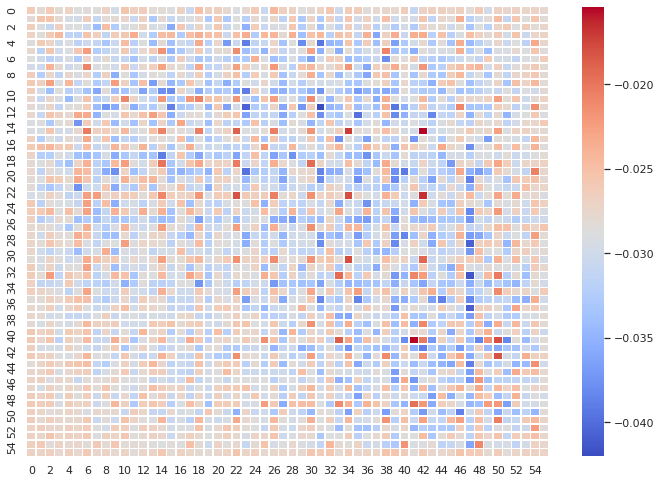

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
#7 left elbow 8 right elbow
sns.heatmap( torch.squeeze(cmap)[8, :, :] , linewidth = 0.5 , cmap = 'coolwarm',)
plt.show()

tensor([[ 0,  1, 15, 13],
        [ 2,  3, 13, 11],
        [ 4,  5, 16, 14],
        [ 6,  7, 14, 12],
        [ 8,  9, 11, 12],
        [10, 11,  5,  7],
        [12, 13,  6,  8],
        [14, 15,  7,  9],
        [16, 17,  8, 10],
        [18, 19,  1,  2],
        [20, 21,  0,  1],
        [22, 23,  0,  2],
        [24, 25,  1,  3],
        [26, 27,  2,  4],
        [28, 29,  3,  5],
        [30, 31,  4,  6],
        [32, 33, 17,  0],
        [34, 35, 17,  5],
        [36, 37, 17,  6],
        [38, 39, 17, 11],
        [40, 41, 17, 12]], dtype=torch.int32) torch.Size([21, 4])
counts=tensor([0], dtype=torch.int32)


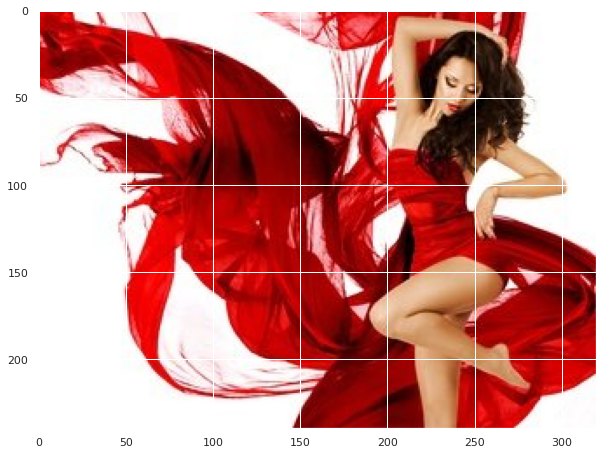

In [30]:
parse_objects = ParseObjects(topology,
                             cmap_threshold=0.1,
                             link_threshold=0.1,
                             cmap_window=5,
                             line_integral_samples=7,
                             max_num_parts=100,
                             max_num_objects=100)
draw_objects = DrawObjects(topology)
print(topology, topology.size())

counts, objects, normalized_peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
print(f"{counts=}")
image_overlay = image.copy()
draw_objects(image_overlay, counts, objects, normalized_peaks)

plt.figure(figsize=(10, 10))
plt.imshow(image_overlay)

tensor([[ 0,  1, 15, 13],
        [ 2,  3, 13, 11],
        [ 4,  5, 16, 14],
        [ 6,  7, 14, 12],
        [ 8,  9, 11, 12],
        [10, 11,  5,  7],
        [12, 13,  6,  8],
        [14, 15,  7,  9],
        [16, 17,  8, 10],
        [18, 19,  1,  2],
        [20, 21,  0,  1],
        [22, 23,  0,  2],
        [24, 25,  1,  3],
        [26, 27,  2,  4],
        [28, 29,  3,  5],
        [30, 31,  4,  6],
        [32, 33, 17,  0],
        [34, 35, 17,  5],
        [36, 37, 17,  6],
        [38, 39, 17, 11],
        [40, 41, 17, 12]], dtype=torch.int32) torch.Size([21, 4])
counts=tensor([100], dtype=torch.int32)


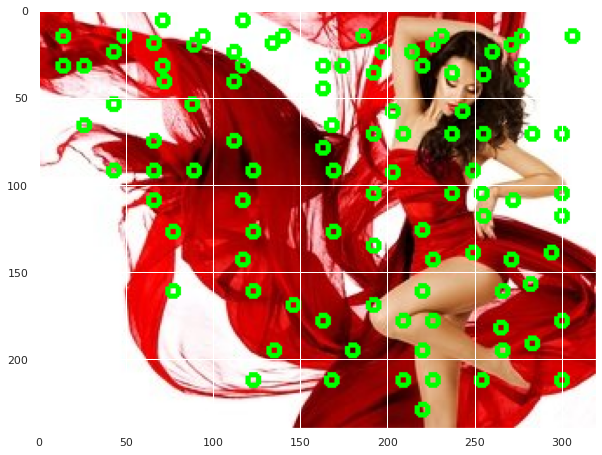

In [36]:
parse_objects = ParseObjects(topology,
                             cmap_threshold=0.03,
                             link_threshold=0.1,
                             cmap_window=5,
                             line_integral_samples=7,
                             max_num_parts=100,
                             max_num_objects=100)
draw_objects = DrawObjects(topology)
print(topology, topology.size())

counts, objects, normalized_peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
print(f"{counts=}")
image_overlay = image.copy()
draw_objects(image_overlay, counts, objects, normalized_peaks)

plt.figure(figsize=(10, 10))
plt.imshow(image_overlay)